# COS利用のための設定

In [1]:
import ibm_boto3
from ibm_botocore.client import Config
import os
import json
import warnings
import time

In [2]:
cos_credentials = {
  "apikey": "0whJuSdqrfEF2Zb-Dgc6Hjb3xFgrhLu2WvJt5VZHb9g5",
  "cos_hmac_keys": {
    "access_key_id": "82641721d527475aa62058fba6f44b15",
    "secret_access_key": "96d2c8ad273d4467a2596005135ec143647541f5e2c06be6"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/0960d86217f3b669ae4408f3b4deaa08:38bc5a04-c294-44d0-93d3-57a963ea4f0d::",
  "iam_apikey_name": "auto-generated-apikey-82641721-d527-475a-a620-58fba6f44b15",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/0960d86217f3b669ae4408f3b4deaa08::serviceid:ServiceId-9a2940d6-dc11-45f0-89d3-2d41ef7deee3",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/0960d86217f3b669ae4408f3b4deaa08:38bc5a04-c294-44d0-93d3-57a963ea4f0d::"
}

In [2]:
# 個別に設定して下さい
cos_credentials = {
  "apikey": "xxxxx",
  "cos_hmac_keys": {
    "access_key_id": "xxxxx",
    "secret_access_key": "xxxxx"
  },
  "endpoints": "https://cos-service.bluemix.net/endpoints",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:cloud-object-storage:global:a/0960d86217f3b669ae4408f3b4deaa08:38bc5a04-c294-44d0-93d3-57a963ea4f0d::",
  "iam_apikey_name": "xxxxx",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "xxxxx",
  "resource_instance_id": "xxxxx"
}

In [3]:
api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.bluemix.net/oidc/token'
service_endpoint = 'https://s3-api.us-geo.objectstorage.softlayer.net'

In [4]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

In [5]:
# 入力backetと出力backetの定義
# 個別に行って下さい
buckets = ['dlaas-input-aka1', 'dlaas-output-aka1']

In [5]:
# 入力backetと出力backetの定義
# 個別に行って下さい
buckets = ['xxxxx', 'yyyyy']

In [6]:
for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

In [7]:
print(list(cos.buckets.all()))

[s3.Bucket(name='20180328project0d195723b6474adbbe32a88e80167381'), s3.Bucket(name='bucket-aka-1'), s3.Bucket(name='dlaas-input-aka1'), s3.Bucket(name='dlaas-output-aka1'), s3.Bucket(name='dltest1860e226fce334f69b71ebf5726a66f81'), s3.Bucket(name='input-backet-aka2'), s3.Bucket(name='testvrb4a94a00382c471b948ca35468df71a0'), s3.Bucket(name='vrproject7ac8b023068546a08745a4abd939c5aa'), s3.Bucket(name='watsonstudio20180413-donotdelete-pr-zejryh21crj12z'), s3.Bucket(name='xxx-donotdelete-pr-ktftsnknk5rqbj')]


# mnintデータをダウンロードしCOSに保存します

In [8]:
!pip install wget

  Running setup.py bdist_wheel for wget ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [9]:
link = 'https://s3.amazonaws.com/img-datasets/mnist.npz'
import wget, os

data_dir = 'MNIST_KERAS_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

if not os.path.isfile(os.path.join(data_dir, os.path.join(link.split('/')[-1]))):
    wget.download(link, out=data_dir)  
        
!ls MNIST_KERAS_DATA

mnist.npz


In [10]:
# データファイルを入力bucketにアップロードします
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))
        
# アップロードしたファイルの確認
for obj in bucket_obj.objects.all():
    print('Object key: {}'.format(obj.key))
    print('Object size (kb): {}'.format(obj.size/1024))

mnist.npz is uploaded.
Object key: cifar-10-tf-test.pkl
Object size (kb): 30078.3701171875
Object key: cifar-10-tf-train.pkl
Object size (kb): 120039.2705078125
Object key: cifar-10-tf-valid.pkl
Object size (kb): 30009.9736328125
Object key: mnist-tf-test.pkl
Object size (kb): 7666.21875
Object key: mnist-tf-train.pkl
Object size (kb): 38330.28125
Object key: mnist-tf-valid.pkl
Object size (kb): 7666.21875
Object key: mnist.npz
Object size (kb): 11221.126953125


# Watson Machine Learning管理クライアントでの作業

In [12]:
!rm -rf $PIP_BUILD/watson-machine-learning-client
!pip install --upgrade watson-machine-learning-client

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: certifi in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: lomond in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tabulate in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: ibm-cos-sdk in /opt/conda/envs/DSX-Python

In [13]:
import urllib3, requests, json, base64, time, os
warnings.filterwarnings('ignore')

In [14]:
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "username": "31d06067-217f-4165-be5e-f96a791156b3",
  "password": "6eb221b4-5cc8-457e-93aa-6213a27a466d",
  "instance_id": "0f8dab2b-453e-41e6-84d4-92bfc5546426"
}

In [14]:
# Watson Machine LearningのCredntial情報
# 個別に設定して下さい。
wml_credentials = {
  "url": "https://ibm-watson-ml.mybluemix.net",
  "username": "xxxxx",
  "password": "xxxxx",
  "instance_id": "xxxxx"
}

In [15]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
client = WatsonMachineLearningAPIClient(wml_credentials)
print(client.version)

1.0.109


2018-04-27 10:48:40,724 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.
2018-04-27 10:48:45,998 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.
2018-04-27 11:03:31,356 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.
2018-04-27 11:33:10,277 - watson_machine_learning_client.wml_client_error - WARNING - Failure during scoring. (POST https://ibm-watson-ml.mybluemix.net/v3/wml_instances/0f8dab2b-453e-41e6-84d4-92bfc5546426/published_models/6d24500c-20e3-44ef-96e9-b8cd1f1b90f5/deployments/ab5df80d-c909-4a2e-8eca-acc8d41084a2/online)
Status code: 400, body: {"trace": "1126404279", "errors": [{"code": "invalid_input_format", "message": "Incorrect input format has been provided: Error when checking : expected dense_1_input to have 2 dimensions, but got array with shape (2, 28, 28, 1)"}], "status_c

# Trainingの定義

In [16]:
# Authorの定義　個別に行って下さい
author_email = 'xxx@ibm.com'

In [17]:
model_definition_metadata = {
            client.repository.DefinitionMetaNames.NAME: "MNIST-MLP",
            client.repository.DefinitionMetaNames.AUTHOR_EMAIL: author_email,
            client.repository.DefinitionMetaNames.FRAMEWORK_NAME: "tensorflow",
            client.repository.DefinitionMetaNames.FRAMEWORK_VERSION: "1.5",
            client.repository.DefinitionMetaNames.RUNTIME_NAME: "python",
            client.repository.DefinitionMetaNames.RUNTIME_VERSION: "3.5",
            client.repository.DefinitionMetaNames.EXECUTION_COMMAND: "python3 mnist_mlp.py"
            }

In [18]:
# モデル定義 (Python/Kerasのコード)のダウンロード
# MNIST.zipにはmnist-nlp.pyとmninst-cnn.pyの2つのコードが含まれていますが、以下のサンプルでは
# mnist-nlp.pyのみを利用します

!rm -rf MNIST.zip

filename_mnist = 'MNIST.zip'

if os.path.isfile(filename_mnist):
    !ls 'MNIST.zip'
else:
    !wget https://github.com/pmservice/wml-sample-models/raw/master/keras/mnist/MNIST.zip
    !ls 'MNIST.zip'

--2018-04-27 10:45:47--  https://github.com/pmservice/wml-sample-models/raw/master/keras/mnist/MNIST.zip
Resolving github.com (github.com)... 192.30.253.113, 192.30.253.112
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/wml-sample-models/master/keras/mnist/MNIST.zip [following]
--2018-04-27 10:45:47--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/keras/mnist/MNIST.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3836 (3.7K) [application/zip]
Saving to: ‘MNIST.zip’

100%[======================================>] 3,836       --.-K/s   in 0.001s  

2018-04-27 10:45:48 (3.21 MB/s) - ‘MNIST.zip’ saved [3836/3836]

MNIST.zip


In [20]:
# リポジトリに定義ファイルの登録
definition_details = client.repository.store_definition(filename_mnist, model_definition_metadata)

definition_url = client.repository.get_definition_url(definition_details)
definition_uid = client.repository.get_definition_uid(definition_details)
print(definition_url)

https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/c662fe2c-b77a-46e3-8476-695e1f044391


In [21]:
# 定義ファイルの一覧
client.repository.list_definitions()

------------------------------------  -------------------------------------------------  ------------------------  ----------
GUID                                  NAME                                               CREATED                   FRAMEWORK
90e0bd84-88bc-4f1f-8198-e6e3852983b2  TENT pred                                          2018-04-13T07:15:43.505Z  wml
10f36b94-4c64-46f2-845d-48e6c2f73dc5  Tent-pred                                          2018-04-13T09:22:19.699Z  wml
d6a3ce6c-27e3-45bc-8c17-8e909c5b72c0  test-pred300                                       2018-04-13T09:26:06.992Z  wml
bc17f865-c385-4f8b-a015-37b5074714f7  MNIST v1                                           2018-04-13T11:06:47.185Z  tensorflow
5a05d09d-ff8d-450b-a72c-262dadd3a52c  CIFAR10 v1                                         2018-04-13T11:09:52.326Z  tensorflow
51ff1d51-b8bb-4883-a9bd-09e504e9e1c7  MNIST v2                                           2018-04-16T00:32:31.568Z  tensorflow
3ba0d4f4-88cf-

# Experimentの定義

In [22]:
# サポートしている項目の一覧表示
client.repository.ExperimentMetaNames.show()

--------------------------  ----  --------
META_PROP NAME              TYPE  REQUIRED
NAME                        str   Y
TAGS                        list  N
DESCRIPTION                 str   N
AUTHOR_NAME                 str   N
EVALUATION_METHOD           str   N
EVALUATION_METRICS          list  N
TRAINING_REFERENCES         list  Y
TRAINING_DATA_REFERENCE     dict  Y
TRAINING_RESULTS_REFERENCE  dict  Y
--------------------------  ----  --------


In [23]:
# 学習時の入力用bucketの定義
TRAINING_DATA_REFERENCE = {
                            "connection": {
                                "endpoint_url": service_endpoint,
                                "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                            },
                            "source": {
                                "bucket": buckets[0],
                            },
                            "type": "s3"
}

In [24]:
# 学習時の出力用bucketの定義
TRAINING_RESULTS_REFERENCE = {
                                "connection": {
                                    "endpoint_url": service_endpoint,
                                    "aws_access_key_id": cos_credentials['cos_hmac_keys']['access_key_id'],
                                    "aws_secret_access_key": cos_credentials['cos_hmac_keys']['secret_access_key']
                                },
                                "target": {
                                    "bucket": buckets[1],
                                },
                                "type": "s3"
}

#### HPOパラメータの指定

**val_acc**(検証データの認識率)を最大にしたいので、これをOptimizerのObjectiveにしています。  
**num_optimizer_steps**で、どの程度細かくパラメータを変化させるかを指定します。

In [25]:
HPO = {
        "method": {
            "name": "rbfopt",
            "parameters": [
                client.experiments.HPOMethodParam("objective", "val_acc"),
                client.experiments.HPOMethodParam("maximize_or_minimize", "maximize"),
                client.experiments.HPOMethodParam("num_optimizer_steps", 3)
            ]
        },
        "hyper_parameters": [
            client.experiments.HPOParameter('learning_rate', min=0.0001, max=0.001, step=0.0003)
        ]
     }           

TRAINING_REFERENCESの定義で、前に定義した**TRAINING**の設定を参照します。

In [29]:
experiment_metadata = {
            client.repository.ExperimentMetaNames.NAME: "MNIST experiment",
            client.repository.ExperimentMetaNames.DESCRIPTION: "Best model for MNIST.",
            client.repository.ExperimentMetaNames.AUTHOR_EMAIL: "akaishi@jp.ibm.com",
            client.repository.ExperimentMetaNames.EVALUATION_METHOD: "multiclass",
            client.repository.ExperimentMetaNames.EVALUATION_METRICS: ["val_acc"],
            client.repository.ExperimentMetaNames.TRAINING_DATA_REFERENCE: TRAINING_DATA_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_RESULTS_REFERENCE: TRAINING_RESULTS_REFERENCE,
            client.repository.ExperimentMetaNames.TRAINING_REFERENCES: [
                        {
                            "name": "MNIST_MLP",
                            "training_definition_url": definition_url,
                            "compute_configuration": {"name": "k80x2"},
                            "hyper_parameters_optimization": HPO
                        }],
            }

#### experimentをリポジトリに登録します

In [30]:
experiment_details = client.repository.store_experiment(meta_props=experiment_metadata)
experiment_uid = client.repository.get_experiment_uid(experiment_details)
print(experiment_uid)

99e56e6c-5b19-4a9d-a7c7-078cbc881a82


#### 登録済みexperimentsの一覧表示

In [31]:
client.repository.list_experiments()

------------------------------------  ----------------  ------------------------
GUID                                  NAME              CREATED
0bc91158-b5b0-44f2-8875-f26c9bf71989  MNIST experiment  2018-04-24T13:35:00.451Z
7e9cb95e-0815-4b56-b840-b268d7a31985  CIFAR10           2018-04-16T23:51:11.838Z
99e56e6c-5b19-4a9d-a7c7-078cbc881a82  MNIST experiment  2018-04-27T11:03:31.611Z
ce134ada-2bdc-4727-9ebf-1acef1144d8a  Simple NMINST     2018-04-16T23:48:35.843Z
------------------------------------  ----------------  ------------------------


In [32]:
# 参考コード

# 既存のexperimentの更新
# updated_experiment_details = client.repository.update_experiment(experiment_uid, experiment_metadata)

# experiment定義の取得
# details = client.repository.get_experiment_details(experiment_uid)

# experiment定義の削除
# client.repository.delete(experiment_uid)

# experimentの実行

In [33]:
experiment_run_details = client.experiments.run(experiment_uid, asynchronous=True)

In [37]:
# experimentの状況確認
client.experiments.list_runs()

------------------------------------  ------------------------------------  -----------------  ---------  --------------------
GUID (experiment)                     GUID (run)                            NAME (experiment)  STATE      CREATED
0bc91158-b5b0-44f2-8875-f26c9bf71989  3caf7407-ca7a-41a5-b4c9-0ae2aaf2612e  MNIST experiment   completed  2018-04-24T13:36:43Z
7e9cb95e-0815-4b56-b840-b268d7a31985  385518ad-a08e-400d-804d-e7aac342bdc0  CIFAR10            completed  2018-04-16T23:51:11Z
99e56e6c-5b19-4a9d-a7c7-078cbc881a82  491e84f7-aed4-43ca-9acf-c9c30d6fbd78  MNIST experiment   running    2018-04-27T11:08:09Z
ce134ada-2bdc-4727-9ebf-1acef1144d8a  f4837889-270e-4649-bd46-d44ec9c9a280  Simple NMINST      completed  2018-04-16T23:48:36Z
------------------------------------  ------------------------------------  -----------------  ---------  --------------------


In [36]:
# experiment run_uidの取得
experiment_run_uid = client.experiments.get_run_uid(experiment_run_details)
print(experiment_run_uid)

491e84f7-aed4-43ca-9acf-c9c30d6fbd78


In [38]:
# training run内の個別テスト結果の取得
client.experiments.list_training_runs(experiment_run_uid)

--------------------  ---------  ---------  --------------------  --------------------  -----------------
GUID (training)       NAME       STATE      SUBMITTED             FINISHED              PERFORMANCE
training-DyIrG4MmR    MNIST_MLP  completed  2018-04-27T11:08:11Z  2018-04-27T11:12:11Z  -
training-DyIrG4MmR_0  MNIST_MLP  completed  2018-04-27T11:08:11Z  -                     train:acc=0.9530
                                                                                        train:loss=0.1574
training-DyIrG4MmR_1  MNIST_MLP  completed  2018-04-27T11:08:11Z  -                     train:acc=0.9812
                                                                                        train:loss=0.0619
training-DyIrG4MmR_2  MNIST_MLP  completed  2018-04-27T11:09:22Z  -                     train:acc=0.9806
                                                                                        train:loss=0.0642
--------------------  ---------  ---------  --------------------  -----

In [39]:
# 詳細結果の取得
experiment_run_details = client.experiments.get_run_details(experiment_run_uid)

In [40]:
# experiment実行状況の取得
client.experiments.get_status(experiment_run_uid)

{'best_results': {'experiment_best_model': {'training_guid': 'training-DyIrG4MmR_2',
   'training_reference_name': 'MNIST_MLP',
   'training_url': 'https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/c662fe2c-b77a-46e3-8476-695e1f044391'},
  'training_reference_best_model': [{'training_guid': 'training-DyIrG4MmR_2',
    'training_reference_name': 'MNIST_MLP',
    'training_url': 'https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/c662fe2c-b77a-46e3-8476-695e1f044391'}]},
 'current_at': '2018-04-27T11:08:09Z',
 'current_iteration': 1,
 'state': 'completed',
 'submitted_at': '2018-04-27T11:08:09Z'}

In [41]:
# 詳細状況の取得
experiment_details = client.experiments.get_details(experiment_uid)
print(json.dumps(experiment_details, indent=2))

{
  "resources": [
    {
      "metadata": {
        "created_at": "2018-04-27T11:08:09Z",
        "modified_at": "2018-04-27T11:08:09Z",
        "guid": "491e84f7-aed4-43ca-9acf-c9c30d6fbd78",
        "url": "/v3/experiments/99e56e6c-5b19-4a9d-a7c7-078cbc881a82/runs/491e84f7-aed4-43ca-9acf-c9c30d6fbd78"
      },
      "entity": {
        "experiment_run_status": {
          "state": "completed",
          "submitted_at": "2018-04-27T11:08:09Z",
          "current_at": "2018-04-27T11:08:09Z",
          "current_iteration": 1,
          "best_results": {
            "training_reference_best_model": [
              {
                "training_guid": "training-DyIrG4MmR_2",
                "training_url": "https://ibm-watson-ml.mybluemix.net/v3/ml_assets/training_definitions/c662fe2c-b77a-46e3-8476-695e1f044391",
                "training_reference_name": "MNIST_MLP"
              }
            ],
            "experiment_best_model": {
              "training_guid": "training-DyIrG4MmR_2"

In [42]:
# training runs uidsの取得
experiment_run_details = client.experiments.get_run_details(experiment_run_uid)
training_run_uids = client.experiments.get_training_uids(experiment_run_details)

for i in training_run_uids:
    print(i)

training-DyIrG4MmR
training-DyIrG4MmR_0
training-DyIrG4MmR_1
training-DyIrG4MmR_2


# モニター機能

In [43]:
# experiment runのモニター
client.experiments.monitor_logs(experiment_run_uid)



########################################################################

Monitor started for experiment run: 491e84f7-aed4-43ca-9acf-c9c30d6fbd78

########################################################################




--------------------------------------------------------
Log monitor started for training run: training-DyIrG4MmR
--------------------------------------------------------


2018-04-27 11:08:51.478826: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA

2018-04-27 11:08:51.805830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1105] Found device 0 with properties: 

name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235

pciBusID: 0000:83:00.0

totalMemory: 11.17GiB freeMemory: 11.10GiB

2018-04-27 11:08:52.069176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1105] Found device 1 with properties: 

name: Tesla K80 major: 3 minor: 7 mem

In [44]:
# statusの確認
client.experiments.get_status(experiment_run_uid)['state']

'completed'

# 品質の確認

In [45]:
!pip install cufflinks

    100% |████████████████████████████████| 51kB 6.7MB/s eta 0:00:01
Requirement not upgraded as not directly required: pandas in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from cufflinks)
Requirement not upgraded as not directly required: plotly>=2.0.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from cufflinks)
Requirement not upgraded as not directly required: python-dateutil>=2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pandas->cufflinks)
Requirement not upgraded as not directly required: pytz>=2011k in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pandas->cufflinks)
Requirement not upgraded as not directly required: numpy>=1.9.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pandas->cufflinks)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from plotly>=2.0.0->cufflinks)
Requirement not upgraded as not directly required:

In [46]:
# metricsの取得
metrics = client.experiments.get_latest_metrics(experiment_run_uid)
all_metrics = client.experiments.get_metrics(experiment_run_uid)

In [47]:
import sys
import pandas
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objs as go

init_notebook_mode(connected=True)
sys.path.append("".join([os.environ["HOME"]])) 

In [48]:
# Pandasでmetricsの表示
import pandas as pd

metrics_df = pd.DataFrame(columns=['GUID', 'NAME', 'METRIC NAME', 'METRIC VALUE'])

for m in metrics:
    for v in m['metrics']['values']:
            metrics_df = metrics_df.append({'GUID': m['training_guid'], 'NAME': m['training_reference_name'], 'METRIC NAME': v['name'], 'METRIC VALUE': v['value']}, ignore_index=True)
    
metrics_df

,GUID,NAME,METRIC NAME,METRIC VALUE
0,training-DyIrG4MmR_0,MNIST_MLP,acc,0.953017
1,training-DyIrG4MmR_0,MNIST_MLP,loss,0.157369
2,training-DyIrG4MmR_1,MNIST_MLP,loss,0.061897
3,training-DyIrG4MmR_1,MNIST_MLP,acc,0.981233
4,training-DyIrG4MmR_2,MNIST_MLP,acc,0.980633
5,training-DyIrG4MmR_2,MNIST_MLP,loss,0.064216


In [49]:
# バーチャートでグラフ化
data = []
for i in list(pd.unique(metrics_df['METRIC NAME'])):
    data.append(go.Bar(x=metrics_df[metrics_df['METRIC NAME'].isin([i])]['GUID'] + ' (' + metrics_df[metrics_df['METRIC NAME'].isin([i])]['NAME'] + ')', y=metrics_df[metrics_df['METRIC NAME'].isin([i])]['METRIC VALUE'], name=i))
layout = go.Layout(
    barmode='group'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# オンラインサービスのデプロイ

In [50]:
status = client.experiments.get_status(experiment_run_uid)
best_model_uid = status['best_results']['experiment_best_model']['training_guid']
best_model_name = status['best_results']['experiment_best_model']['training_reference_name']

print(best_model_uid + ' (' +  best_model_name  + ')')

training-DyIrG4MmR_2 (MNIST_MLP)


In [51]:
saved_model_details = client.repository.store_model(best_model_uid, {'name': 'MNIST best model'})

In [52]:
model_guid = client.repository.get_model_uid(saved_model_details)
print("Saved model guid: " + model_guid)

Saved model guid: 6d24500c-20e3-44ef-96e9-b8cd1f1b90f5


In [53]:
client.repository.list_models()

------------------------------------  -----------------------  ------------------------  -----------------
GUID                                  NAME                     CREATED                   FRAMEWORK
8d105f5e-59e9-4af9-b502-e9fa6c0917c4  mnist1                   2018-04-16T23:59:05.732Z  tensorflow-1.5
a630875d-d183-4178-9cf7-4a6c79a8000b  CIFAR10                  2018-04-17T01:00:55.550Z  tensorflow-1.5
33aeec66-407e-4a31-b8c8-b599498f24e4  MNIST best model         2018-04-24T13:50:51.040Z  tensorflow-1.5
f3834096-9aeb-4e84-8844-650150514d71  Tent-Sell-Predict        2018-04-26T10:57:55.153Z  wml-1.1
8fbeb37d-9c55-4cc4-aa98-4b336e8d2e30  Digits prediction model  2018-04-26T12:10:29.729Z  scikit-learn-0.19
5028d53c-e0ad-4e02-bf01-bcacdfb226ef  Digits prediction model  2018-04-27T04:49:51.071Z  scikit-learn-0.19
6d24500c-20e3-44ef-96e9-b8cd1f1b90f5  MNIST best model         2018-04-27T11:29:59.655Z  tensorflow-1.5
------------------------------------  -----------------------  ----

In [54]:
deployment_details = client.deployments.create(name="MNIST keras deployment", model_uid=model_guid)



#######################################################################################

Synchronous deployment creation for uid: 'ab5df80d-c909-4a2e-8eca-acc8d41084a2' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS.
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ab5df80d-c909-4a2e-8eca-acc8d41084a2'
------------------------------------------------------------------------------------------------




In [55]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://ibm-watson-ml.mybluemix.net/v3/wml_instances/0f8dab2b-453e-41e6-84d4-92bfc5546426/published_models/6d24500c-20e3-44ef-96e9-b8cd1f1b90f5/deployments/ab5df80d-c909-4a2e-8eca-acc8d41084a2/online


# 予測実行

11493376/11490434 [==============================] - 2s 0us/step


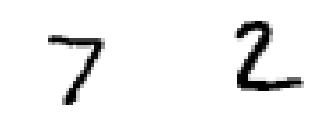

In [56]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

In [62]:
image_1 = x_test[0].ravel()
image_2 = x_test[1].ravel()
scoring_data = {'values': [image_1.tolist(), image_2.tolist()]}
predictions = client.deployments.score(scoring_url, scoring_data)
print("Scoring result: " + str(predictions))

Scoring result: {'values': [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 7, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]], [[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 2, [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]], 'fields': ['prediction', 'prediction_classes', 'probability']}
